# Method 7 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

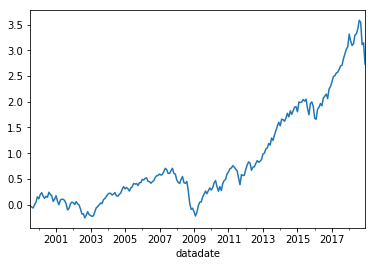

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.151578
2000-12-31   -0.040451
2001-12-31   -0.051865
2002-12-31   -0.232182
2003-12-31    0.438702
2004-12-31    0.164751
2005-12-31    0.058745
2006-12-31    0.097790
2007-12-31    0.016747
2008-12-31   -0.416424
2009-12-31    0.423842
2010-12-31    0.206535
2011-12-31   -0.019086
2012-12-31    0.199306
2013-12-31    0.384173
2014-12-31    0.116748
2015-12-31    0.001512
2016-12-31    0.134025
2017-12-31    0.233707
2018-12-31   -0.082212
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2864.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.26e-194
Time:                        21:51:21   Log-Likelihood:                 830.98
No. Observations:                 234   AIC:                            -1652.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.225      0.000       0.001       0.003
mktrf          1.0645      0.013     81.331      0.000       1.039       1.090
me             0.1794      0.015     11.781      0.000       0.149       0.209
ia             0.0410      0.023      1.771      0.078      -0.005       0.087
roe           -0.0453      0.020     -2.286      0.023      -0.084      -0.006
==============================================================================
Omnibus:                       21.820   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.176
Skew:                          -0.144   Prob(JB):                     8.68e-19
Kurtosis:                       5.907   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3078.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.00e-197
Time:                        21:51:21   Log-Likelihood:                 830.98
No. Observations:                 234   AIC:                            -1652.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.908      0.000       0.001       0.003
mktrf          1.0645      0.013     83.485      0.000       1.039       1.089
me             0.1794      0.019      9.249      0.000       0.141       0.217
ia             0.0410      0.044      0.931      0.352      -0.045       0.127
roe           -0.0453      0.032     -1.434      0.152      -0.107       0.017
==============================================================================
Omnibus:                       21.820   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.176
Skew:                          -0.144   Prob(JB):                     8.68e-19
Kurtosis:                       5.907   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3453.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.40e-203
Time:                        21:51:21   Log-Likelihood:                 830.98
No. Observations:                 234   AIC:                            -1652.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.573      0.000       0.001       0.003
mktrf          1.0645      0.012     86.511      0.000       1.040       1.089
me             0.1794      0.017     10.789      0.000       0.147       0.212
ia             0.0410      0.044      0.929      0.353      -0.045       0.127
roe           -0.0453      0.035     -1.302      0.193      -0.113       0.023
==============================================================================
Omnibus:                       21.820   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.176
Skew:                          -0.144   Prob(JB):                     8.68e-19
Kurtosis:                       5.907   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1992.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.79e-186
Time:                        21:51:21   Log-Likelihood:                 815.47
No. Observations:                 234   AIC:                            -1619.
Df Residuals:                     228   BIC:                            -1598.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.626      0.000       0.001       0.003
mktrf          1.0707      0.014     76.241      0.000       1.043       1.098
smb            0.1928      0.019     10.405      0.000       0.156       0.229
hml            0.0587      0.022      2.687      0.008       0.016       0.102
rmw           -0.0423      0.025     -1.712      0.088      -0.091       0.006
cma           -0.0092      0.031     -0.292      0.770      -0.071       0.053
==============================================================================
Omnibus:                       21.513   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.004
Skew:                           0.140   Prob(JB):                     2.57e-18
Kurtosis:                       5.869   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1705.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.24e-178
Time:                        21:51:21   Log-Likelihood:                 815.47
No. Observations:                 234   AIC:                            -1619.
Df Residuals:                     228   BIC:                            -1598.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.293      0.001       0.001       0.003
mktrf          1.0707      0.015     71.418      0.000       1.041       1.100
smb            0.1928      0.023      8.379      0.000       0.148       0.238
hml            0.0587      0.040      1.483      0.138      -0.019       0.136
rmw           -0.0423      0.037     -1.150      0.250      -0.114       0.030
cma           -0.0092      0.042     -0.219      0.826      -0.091       0.073
==============================================================================
Omnibus:                       21.513   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.004
Skew:                           0.140   Prob(JB):                     2.57e-18
Kurtosis:                       5.869   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1971.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.23e-185
Time:                        21:51:21   Log-Likelihood:                 815.47
No. Observations:                 234   AIC:                            -1619.
Df Residuals:                     228   BIC:                            -1598.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.950      0.003       0.001       0.003
mktrf          1.0707      0.015     71.185      0.000       1.041       1.100
smb            0.1928      0.020      9.752      0.000       0.154       0.232
hml            0.0587      0.040      1.464      0.143      -0.020       0.137
rmw           -0.0423      0.036     -1.179      0.239      -0.113       0.028
cma           -0.0092      0.041     -0.222      0.824      -0.090       0.072
==============================================================================
Omnibus:                       21.513   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.004
Skew:                           0.140   Prob(JB):                     2.57e-18
Kurtosis:                       5.869   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2424.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.15e-186
Time:                        21:51:21   Log-Likelihood:                 811.91
No. Observations:                 234   AIC:                            -1614.
Df Residuals:                     229   BIC:                            -1597.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.696      0.000       0.001       0.003
mktrf          1.0690      0.013     81.768      0.000       1.043       1.095
smb            0.2018      0.016     12.364      0.000       0.170       0.234
hml            0.0716      0.016      4.414      0.000       0.040       0.104
umd           -0.0311      0.011     -2.925      0.004      -0.052      -0.010
==============================================================================
Omnibus:                       14.973   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.327
Skew:                           0.026   Prob(JB):                     6.44e-10
Kurtosis:                       5.083   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2126.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.67e-180
Time:                        21:51:21   Log-Likelihood:                 811.91
No. Observations:                 234   AIC:                            -1614.
Df Residuals:                     229   BIC:                            -1597.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.928      0.003       0.001       0.003
mktrf          1.0690      0.018     60.418      0.000       1.034       1.104
smb            0.2018      0.018     11.100      0.000       0.166       0.237
hml            0.0716      0.041      1.737      0.082      -0.009       0.152
umd           -0.0311      0.019     -1.645      0.100      -0.068       0.006
==============================================================================
Omnibus:                       14.973   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.327
Skew:                           0.026   Prob(JB):                     6.44e-10
Kurtosis:                       5.083   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2472.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.81e-187
Time:                        21:51:21   Log-Likelihood:                 811.91
No. Observations:                 234   AIC:                            -1614.
Df Residuals:                     229   BIC:                            -1597.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.634      0.008       0.000       0.003
mktrf          1.0690      0.016     67.479      0.000       1.038       1.100
smb            0.2018      0.017     11.708      0.000       0.168       0.236
hml            0.0716      0.045      1.601      0.109      -0.016       0.159
umd           -0.0311      0.016     -1.895      0.058      -0.063       0.001
==============================================================================
Omnibus:                       14.973   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.327
Skew:                           0.026   Prob(JB):                     6.44e-10
Kurtosis:                       5.083   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1438.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.61e-97
Time:                        21:51:21   Log-Likelihood:                 413.74
No. Observations:                 120   AIC:                            -817.5
Df Residuals:                     115   BIC:                            -803.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.665      0.000       0.001       0.004
mktrf          1.0625      0.020     52.418      0.000       1.022       1.103
me             0.1622      0.020      8.102      0.000       0.123       0.202
ia             0.0945      0.031      3.014      0.003       0.032       0.157
roe           -0.0645      0.028     -2.325      0.022      -0.119      -0.010
==============================================================================
Omnibus:                       12.632   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.399
Skew:                          -0.324   Prob(JB):                     6.81e-07
Kurtosis:                       5.293   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1774.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.58e-102
Time:                        21:51:21   Log-Likelihood:                 413.74
No. Observations:                 120   AIC:                            -817.5
Df Residuals:                     115   BIC:                            -803.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.117      0.002       0.001       0.004
mktrf          1.0625      0.019     56.961      0.000       1.026       1.099
me             0.1622      0.018      8.901      0.000       0.126       0.198
ia             0.0945      0.045      2.121      0.034       0.007       0.182
roe           -0.0645      0.035     -1.858      0.063      -0.133       0.004
==============================================================================
Omnibus:                       12.632   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.399
Skew:                          -0.324   Prob(JB):                     6.81e-07
Kurtosis:                       5.293   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2828.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.40e-114
Time:                        21:51:21   Log-Likelihood:                 413.74
No. Observations:                 120   AIC:                            -817.5
Df Residuals:                     115   BIC:                            -803.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.667      0.008       0.001       0.005
mktrf          1.0625      0.016     65.898      0.000       1.031       1.094
me             0.1622      0.015     10.574      0.000       0.132       0.192
ia             0.0945      0.035      2.685      0.007       0.026       0.163
roe           -0.0645      0.037     -1.755      0.079      -0.137       0.008
==============================================================================
Omnibus:                       12.632   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.399
Skew:                          -0.324   Prob(JB):                     6.81e-07
Kurtosis:                       5.293   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     907.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.91e-90
Time:                        21:51:21   Log-Likelihood:                 400.33
No. Observations:                 120   AIC:                            -788.7
Df Residuals:                     114   BIC:                            -771.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.563      0.001       0.001       0.005
mktrf          1.1024      0.024     45.925      0.000       1.055       1.150
smb            0.1963      0.027      7.221      0.000       0.142       0.250
hml            0.0415      0.033      1.247      0.215      -0.024       0.108
rmw           -0.0191      0.039     -0.487      0.627      -0.097       0.059
cma            0.0594      0.043      1.380      0.170      -0.026       0.145
==============================================================================
Omnibus:                       11.319   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.538
Skew:                          -0.223   Prob(JB):                     1.73e-06
Kurtosis:                       5.260   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1239.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-97
Time:                        21:51:21   Log-Likelihood:                 400.33
No. Observations:                 120   AIC:                            -788.7
Df Residuals:                     114   BIC:                            -771.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.153      0.002       0.001       0.005
mktrf          1.1024      0.028     38.789      0.000       1.047       1.158
smb            0.1963      0.034      5.779      0.000       0.130       0.263
hml            0.0415      0.067      0.621      0.535      -0.090       0.173
rmw           -0.0191      0.062     -0.307      0.759      -0.141       0.103
cma            0.0594      0.044      1.338      0.181      -0.028       0.146
==============================================================================
Omnibus:                       11.319   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.538
Skew:                          -0.223   Prob(JB):                     1.73e-06
Kurtosis:                       5.260   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2207.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.17e-111
Time:                        21:51:21   Log-Likelihood:                 400.33
No. Observations:                 120   AIC:                            -788.7
Df Residuals:                     114   BIC:                            -771.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.768      0.006       0.001       0.005
mktrf          1.1024      0.028     39.518      0.000       1.048       1.157
smb            0.1963      0.031      6.350      0.000       0.136       0.257
hml            0.0415      0.072      0.576      0.564      -0.100       0.183
rmw           -0.0191      0.066     -0.291      0.771      -0.148       0.110
cma            0.0594      0.041      1.464      0.143      -0.020       0.139
==============================================================================
Omnibus:                       11.319   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               26.538
Skew:                          -0.223   Prob(JB):                     1.73e-06
Kurtosis:                       5.260   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1097.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-90
Time:                        21:51:21   Log-Likelihood:                 397.87
No. Observations:                 120   AIC:                            -785.7
Df Residuals:                     115   BIC:                            -771.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.902      0.000       0.002       0.005
mktrf          1.0795      0.020     52.965      0.000       1.039       1.120
smb            0.2052      0.023      8.843      0.000       0.159       0.251
hml            0.0947      0.023      4.074      0.000       0.049       0.141
umd           -0.0310      0.014     -2.164      0.033      -0.059      -0.003
==============================================================================
Omnibus:                        9.134   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               16.484
Skew:                          -0.252   Prob(JB):                     0.000263
Kurtosis:                       4.744   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1406.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.29e-96
Time:                        21:51:21   Log-Likelihood:                 397.87
No. Observations:                 120   AIC:                            -785.7
Df Residuals:                     115   BIC:                            -771.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.504      0.000       0.001       0.005
mktrf          1.0795      0.027     40.693      0.000       1.028       1.132
smb            0.2052      0.022      9.274      0.000       0.162       0.249
hml            0.0947      0.050      1.882      0.060      -0.004       0.193
umd           -0.0310      0.022     -1.384      0.166      -0.075       0.013
==============================================================================
Omnibus:                        9.134   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               16.484
Skew:                          -0.252   Prob(JB):                     0.000263
Kurtosis:                       4.744   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1849.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.47e-103
Time:                        21:51:21   Log-Likelihood:                 397.87
No. Observations:                 120   AIC:                            -785.7
Df Residuals:                     115   BIC:                            -771.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.116      0.002       0.001       0.005
mktrf          1.0795      0.021     51.308      0.000       1.038       1.121
smb            0.2052      0.022      9.494      0.000       0.163       0.248
hml            0.0947      0.054      1.759      0.079      -0.011       0.200
umd           -0.0310      0.018     -1.690      0.091      -0.067       0.005
==============================================================================
Omnibus:                        9.134   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               16.484
Skew:                          -0.252   Prob(JB):                     0.000263
Kurtosis:                       4.744   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1756.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.89e-98
Time:                        21:51:21   Log-Likelihood:                 436.47
No. Observations:                 114   AIC:                            -862.9
Df Residuals:                     109   BIC:                            -849.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.417      0.017       0.000       0.002
mktrf          1.0705      0.016     67.690      0.000       1.039       1.102
me             0.2103      0.024      8.614      0.000       0.162       0.259
ia            -0.1124      0.034     -3.317      0.001      -0.179      -0.045
roe           -0.0555      0.030     -1.866      0.065      -0.115       0.003
==============================================================================
Omnibus:                        2.739   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.246
Skew:                          -0.212   Prob(JB):                        0.325
Kurtosis:                       3.541   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2632.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.10e-107
Time:                        21:51:21   Log-Likelihood:                 436.47
No. Observations:                 114   AIC:                            -862.9
Df Residuals:                     109   BIC:                            -849.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.490      0.000       0.001       0.002
mktrf          1.0705      0.014     77.849      0.000       1.044       1.097
me             0.2103      0.022      9.531      0.000       0.167       0.254
ia            -0.1124      0.034     -3.260      0.001      -0.180      -0.045
roe           -0.0555      0.027     -2.095      0.036      -0.107      -0.004
==============================================================================
Omnibus:                        2.739   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.246
Skew:                          -0.212   Prob(JB):                        0.325
Kurtosis:                       3.541   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2674.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.93e-108
Time:                        21:51:22   Log-Likelihood:                 436.47
No. Observations:                 114   AIC:                            -862.9
Df Residuals:                     109   BIC:                            -849.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.011      0.000       0.001       0.002
mktrf          1.0705      0.013     80.118      0.000       1.044       1.097
me             0.2103      0.021      9.975      0.000       0.169       0.252
ia            -0.1124      0.038     -2.986      0.003      -0.186      -0.039
roe           -0.0555      0.028     -2.009      0.045      -0.110      -0.001
==============================================================================
Omnibus:                        2.739   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.246
Skew:                          -0.212   Prob(JB):                        0.325
Kurtosis:                       3.541   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2183.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.02e-106
Time:                        21:51:22   Log-Likelihood:                 461.79
No. Observations:                 114   AIC:                            -911.6
Df Residuals:                     108   BIC:                            -895.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.412      0.161      -0.000       0.001
mktrf          1.0668      0.012     87.912      0.000       1.043       1.091
smb            0.1593      0.020      8.088      0.000       0.120       0.198
hml            0.0608      0.025      2.420      0.017       0.011       0.111
rmw           -0.1597      0.031     -5.190      0.000      -0.221      -0.099
cma           -0.1925      0.039     -4.930      0.000      -0.270      -0.115
==============================================================================
Omnibus:                        0.720   Durbin-Watson:                   2.369
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.779
Skew:                           0.183   Prob(JB):                        0.677
Kurtosis:                       2.827   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1720.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.42e-101
Time:                        21:51:22   Log-Likelihood:                 461.79
No. Observations:                 114   AIC:                            -911.6
Df Residuals:                     108   BIC:                            -895.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.106      0.035    4.23e-05       0.001
mktrf          1.0668      0.013     79.605      0.000       1.041       1.093
smb            0.1593      0.020      7.910      0.000       0.120       0.199
hml            0.0608      0.025      2.387      0.017       0.011       0.111
rmw           -0.1597      0.026     -6.222      0.000      -0.210      -0.109
cma           -0.1925      0.039     -4.946      0.000      -0.269      -0.116
==============================================================================
Omnibus:                        0.720   Durbin-Watson:                   2.369
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.779
Skew:                           0.183   Prob(JB):                        0.677
Kurtosis:                       2.827   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1781.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.27e-102
Time:                        21:51:22   Log-Likelihood:                 461.79
No. Observations:                 114   AIC:                            -911.6
Df Residuals:                     108   BIC:                            -895.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.012      0.044    1.58e-05       0.001
mktrf          1.0668      0.013     83.561      0.000       1.042       1.092
smb            0.1593      0.019      8.376      0.000       0.122       0.197
hml            0.0608      0.025      2.386      0.017       0.011       0.111
rmw           -0.1597      0.026     -6.237      0.000      -0.210      -0.110
cma           -0.1925      0.040     -4.835      0.000      -0.271      -0.114
==============================================================================
Omnibus:                        0.720   Durbin-Watson:                   2.369
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.779
Skew:                           0.183   Prob(JB):                        0.677
Kurtosis:                       2.827   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1836.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.49e-99
Time:                        21:51:22   Log-Likelihood:                 438.95
No. Observations:                 114   AIC:                            -867.9
Df Residuals:                     109   BIC:                            -854.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.308      0.759      -0.001       0.001
mktrf          1.0792      0.015     73.595      0.000       1.050       1.108
smb            0.1984      0.023      8.676      0.000       0.153       0.244
hml           -0.0066      0.024     -0.281      0.779      -0.053       0.040
umd           -0.0388      0.018     -2.182      0.031      -0.074      -0.004
==============================================================================
Omnibus:                        0.140   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.195
Skew:                           0.081   Prob(JB):                        0.907
Kurtosis:                       2.879   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1901.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.29e-100
Time:                        21:51:22   Log-Likelihood:                 438.95
No. Observations:                 114   AIC:                            -867.9
Df Residuals:                     109   BIC:                            -854.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.431      0.666      -0.001       0.001
mktrf          1.0792      0.017     63.580      0.000       1.046       1.112
smb            0.1984      0.020     10.033      0.000       0.160       0.237
hml           -0.0066      0.027     -0.249      0.804      -0.059       0.046
umd           -0.0388      0.027     -1.445      0.148      -0.091       0.014
==============================================================================
Omnibus:                        0.140   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.195
Skew:                           0.081   Prob(JB):                        0.907
Kurtosis:                       2.879   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2737.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.53e-108
Time:                        21:51:22   Log-Likelihood:                 438.95
No. Observations:                 114   AIC:                            -867.9
Df Residuals:                     109   BIC:                            -854.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.516      0.606      -0.000       0.001
mktrf          1.0792      0.016     67.252      0.000       1.048       1.111
smb            0.1984      0.016     12.407      0.000       0.167       0.230
hml           -0.0066      0.026     -0.254      0.799      -0.058       0.044
umd           -0.0388      0.028     -1.361      0.174      -0.095       0.017
==============================================================================
Omnibus:                        0.140   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.195
Skew:                           0.081   Prob(JB):                        0.907
Kurtosis:                       2.879   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""